<a href="https://colab.research.google.com/github/EliasVillalvazo/master_deg_documents/blob/main/TidyData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pre-Requisites

- Mount drive to load csv files for this notebook
- Import libraries

In [20]:
# Mount drive to load csv data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load libraries
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm
import numpy as np

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
ls '/content/drive/MyDrive/CS4013/hw1'

deaths08.csv.bz2  icd-main.csv  TidyData.ipynb


## Load CSV file

- CSV file deaths08.csv.bz2 will be read and stored in variable df
- The following cells are just used for debug purposes to observe the information of some variables stored in the dataframe



In [5]:
df = pd.read_csv('/content/drive/MyDrive/CS4013/hw1/deaths08.csv.bz2', compression='bz2')
print(f"DataFrame is of shape: {df.shape}")

DataFrame is of shape: (539530, 46)


In [6]:
df.head()

,yob,mob,dob,sex,age_unit,age,nation,marital,stateL,countyL,locationL,popL,job,edu,derhab,statD,countyD,locationD,popD,placeD,yod,mod,dod,hod,minod,med_help,cod,des,presume,working,injury_loc,domestic_v,autopsy,certifier,state_reg,county_reg,year_reg,mon_reg,day_reg,weight,year_cert,mon_cert,day_cert,pregnant,labor_cod,labor_c
0,1918,0,0,1,A,90,1,2,1,1,239,3,2,2,3,1,1,239,3,11,2008,1,7,20,15,1,F17,2,8,8,88,8,2,1,1,1,2008,1,8,8888,2008,1,7,8,8,8
1,1936,0,0,1,A,72,1,2,1,1,237,3,41,3,2,1,1,1,15,3,2008,1,13,14,25,1,I05,9,8,8,88,8,2,3,1,1,2008,1,14,8888,2008,1,13,8,8,8
2,1959,0,0,1,A,49,1,5,33,0,0,0,41,3,1,1,1,1,15,9,2008,1,12,20,40,1,K65,0,8,8,88,8,2,1,1,1,2008,1,17,8888,2008,1,12,8,8,8
3,1929,0,0,2,A,79,1,5,1,1,237,3,2,2,7,1,1,237,3,11,2008,1,20,10,30,1,I38,X,8,8,88,8,2,3,1,1,2008,1,21,8888,2008,1,20,8,8,8
4,1993,0,0,1,A,15,1,1,1,1,479,4,2,2,0,1,1,479,4,11,2008,1,1,15,0,1,N18,9,8,8,88,8,0,1,1,1,2008,1,2,8888,2008,1,1,8,8,8


In [7]:
# print the range of values of hod
pd.unique(df['hod'])

array([20, 14, 10, 15, 22,  1,  4, 18, 17, 21, 13,  3,  6, 23,  9,  5, 16,
       12,  0, 11,  7, 19,  8,  2, 24, 99])

## Dataframe Manipulation

### Count number of deaths per hour for each cause

Two apporaches are proposed to count the number of deaths in each hour (hod) for each cause (cod) with the pandas-equivalent *count* function

- The first apporach returns a pandas.Series item
- The second approach returns a pandas.DataFrame item

In [8]:
# First, we count the number of deaths in each hour (hod) for each cause (cod) with the tidy count function
deaths = df.copy()
hod2 = deaths.groupby(['hod', 'cod'], dropna=True).size()
hod2.head(10)

hod  cod
0    A02     1
     A04     6
     A06     5
     A09    91
     A15     7
     A16    53
     A17     5
     A18     4
     A19     8
     A27     2
dtype: int64

In [9]:
# Alternative method keeping dataframe
hod3 = pd.DataFrame({'freq' : deaths.groupby(["hod", "cod"]).size()}).reset_index()
# Then we remove missing values with subset
hod3 = hod3.dropna(subset=['hod'])
hod3.head(5)

,hod,cod,freq
0,0,A02,1
1,0,A04,6
2,0,A06,5
3,0,A09,91
4,0,A15,7


### Perform Sanity Check

Sanity check is performed to confirm that the sum of diseases per hour matches the manual exploration. User can visually compare the values returned for a certain hour of death (hod) and disease (cod) from the previous cell with the cell below 

In [10]:
# Sanity check to confirm that the count value corresponds
test =  df.loc[df['hod'] == 0]
test = test.loc[test['cod'] == 'A04']
test

,yob,mob,dob,sex,age_unit,age,nation,marital,stateL,countyL,locationL,popL,job,edu,derhab,statD,countyD,locationD,popD,placeD,yod,mod,dod,hod,minod,med_help,cod,des,presume,working,injury_loc,domestic_v,autopsy,certifier,state_reg,county_reg,year_reg,mon_reg,day_reg,weight,year_cert,mon_cert,day_cert,pregnant,labor_cod,labor_c
3191,1919,0,0,2,A,89,1,2,1,1,1,15,2,5,2,1,1,1,15,9,2008,7,30,0,0,1,A04,9,8,8,88,8,2,1,1,1,2008,8,4,8888,2008,7,30,8,8,8
106895,2008,0,0,2,M,2,1,8,11,26,67,1,98,8,1,11,15,1,11,1,2008,2,7,0,30,1,A04,7,8,8,88,8,2,3,11,15,2008,2,8,8888,2008,2,7,8,8,8
239967,1952,10,20,1,A,56,1,5,9,7,1,17,71,5,7,9,15,1,15,1,2008,12,29,0,30,1,A04,7,8,8,88,8,2,3,9,15,2008,12,29,8888,2008,12,29,8,8,8
314535,1927,8,6,2,A,81,1,5,16,66,1,11,2,5,1,16,66,1,11,11,2008,11,3,0,45,1,A04,9,8,8,88,8,0,1,16,66,2008,11,3,8888,2008,11,3,8,8,8
427085,2008,2,0,1,M,2,1,8,24,46,58,1,98,8,7,24,28,1,15,1,2008,4,19,0,40,1,A04,7,8,8,88,8,2,3,24,28,2008,4,19,8888,2008,4,19,8,8,8
428728,2007,11,0,1,M,3,1,8,24,20,1,11,98,8,7,24,28,1,15,1,2008,2,6,0,30,1,A04,7,8,8,88,8,2,3,24,28,2008,2,6,8888,2008,2,6,8,8,8


### Load ICD dataset

Another dataset will be loaded. This dataset contains the definition of each disease contained in the 'cod' column of the main dataset.

In [11]:
# We next join the dataset to use the codes dataset connected with the cod variable
codes = pd.read_csv('/content/drive/MyDrive/CS4013/hw1/icd-main.csv',)
codes = codes.rename(columns={'code': 'cod'})
codes

,cod,disease
0,A00,Cholera
1,A01,Typhoid and paratyphoid fevers
2,A02,Other salmonella infections
3,A03,Shigellosis
4,A04,Other bacterial intestinal infections
...,...,...
1853,Y85,Sequelae of transport accidents
1854,Y86,Sequelae of other accidents
1855,Y87,"Sequelae of intentional self harm, assault, an..."
1856,Y88,Sequelae with surgical and medical care as ext...


Preprocess the dataset to remove duplicate rows

In [12]:
# Find if there is any duplicate in the code dataset
duplicated = codes.duplicated(subset=['cod'])
df_dup = codes[duplicated]
df_dup

,cod,disease
167,B99,Other and unspecified infectious diseases
213,C50,Malignant neoplasm of breast
257,C97,Malignant neoplasms of independent (primary) m...
485,F99,"Mental disorder, not otherwise specified"
559,H40,Glaucoma
991,N99,Postprocedural disorders of genitourinary syst...
1471,T79,"Certain early complications of trauma, not els..."


In [13]:
# Remove duplicated entries and assure there is no more duplicated elements
codes = codes[~duplicated]
codes.duplicated(subset=['cod']).any()

False

Merge main dataset (stored as hod3) with the dataset containing code definition. We chose to merge using *left* dataframe (hod3) as main, so the codes dataset should adapt to the shape of of hod3 dataframe. Rows with a NaN value happen because the code associated is not found in the original document. 

In [14]:
hod4 = pd.merge(hod3, codes, on='cod', how='left')
hod4

,hod,cod,freq,disease
0,0,A02,1,Other salmonella infections
1,0,A04,6,Other bacterial intestinal infections
2,0,A06,5,Amebiasis
3,0,A09,91,Diarrhea and gastroenteritis of infectious origin
4,0,A15,7,NaN
...,...,...,...,...
16702,99,Y33,2,"Other specified events, undetermined intent"
16703,99,Y34,99,"Unspecified event, undetermined intent"
16704,99,Y40,1,"Adverse effects in therapeutic use, systemic a..."
16705,99,Y57,3,"Adverse effects in therapeutic use, other and ..."


The following cell is used to verify that the output of the merge matches the structure proposed at Table 16 at the document of reference. For instance, at hod = 8 for the disease I21, the number of cases reported are 2205, and the type of disease is "Acute myocardial infraction"

In [16]:
# Example: Victims of avalanche
hod4[hod4['cod'] == 'I21'].head(9)

,hod,cod,freq,disease
223,0,I21,1507,Acute myocardial infarction
890,1,I21,1745,Acute myocardial infarction
1545,2,I21,1542,Acute myocardial infarction
2194,3,I21,1749,Acute myocardial infarction
2847,4,I21,1752,Acute myocardial infarction
3498,5,I21,2095,Acute myocardial infarction
4167,6,I21,2238,Acute myocardial infarction
4848,7,I21,2134,Acute myocardial infarction
5503,8,I21,2205,Acute myocardial infarction


### Compute the proportion for each disease

A new column *prop* is generated. This column contains the proportion of each disease out of the total number of cases. 

In [17]:
hod4['prop'] = hod4.groupby('cod')['freq'].transform('sum')
# Confirm that the proportion is equivalent to the sum of the values in freq
# hod4[hod4['cod'] == 'A01']

In [18]:
# Compute the proportion by performing freq / sum (freq)
hod4['prop'] = hod4['freq'] / hod4['prop']
hod4

,hod,cod,freq,disease,prop
0,0,A02,1,Other salmonella infections,0.015625
1,0,A04,6,Other bacterial intestinal infections,0.041379
2,0,A06,5,Amebiasis,0.056180
3,0,A09,91,Diarrhea and gastroenteritis of infectious origin,0.028807
4,0,A15,7,NaN,0.033333
...,...,...,...,...,...
16702,99,Y33,2,"Other specified events, undetermined intent",0.032258
16703,99,Y34,99,"Unspecified event, undetermined intent",0.110491
16704,99,Y40,1,"Adverse effects in therapeutic use, systemic a...",0.333333
16705,99,Y57,3,"Adverse effects in therapeutic use, other and ...",0.026316


### Compute the overall average rate for each hour

By comparing *prop* to *prop_all*, we can easily compare each disease with the overall incidence pattern.

- Compute the total for each cause of death per hour (first line of code). The value is stored in *freq_all* column and it indicates the total amounf of people that died at a certain hour. Thus, all the *freq_all* values for hod = 0 are equal, all the values for hod = 1 are equal between them, and so on.

- The second line computes the **prop**ortion of deaths in a day. We obtain that by dividing the number of cases at each hour, by the total amount of cases per day. The resulting value is stored in *prop_all* column.

In [21]:
# First we work out the number of people dying each hour. We break by hod and
hod4['freq_all'] = hod4.groupby('hod')['freq'].transform('sum')
# hod4[hod4['cod'] == 'B16']
hod4['prop_all'] = hod4['freq_all'] / hod4['freq'].sum()
hod4

,hod,cod,freq,disease,prop,n,freq_all,prop_all
0,0,A02,1,Other salmonella infections,0.015625,64,20517,0.038028
1,0,A04,6,Other bacterial intestinal infections,0.041379,145,20517,0.038028
2,0,A06,5,Amebiasis,0.056180,89,20517,0.038028
3,0,A09,91,Diarrhea and gastroenteritis of infectious origin,0.028807,3159,20517,0.038028
4,0,A15,7,NaN,0.033333,210,20517,0.038028
...,...,...,...,...,...,...,...,...
16702,99,Y33,2,"Other specified events, undetermined intent",0.032258,62,5043,0.009347
16703,99,Y34,99,"Unspecified event, undetermined intent",0.110491,896,5043,0.009347
16704,99,Y40,1,"Adverse effects in therapeutic use, systemic a...",0.333333,3,5043,0.009347
16705,99,Y57,3,"Adverse effects in therapeutic use, other and ...",0.026316,114,5043,0.009347


### Compute Mean Squared Deviation

We compute a distance between the temporal pattern of each cause of death and the overal temporal pattern. The proposed distance is the mean squared deviation. 

To do so, an additional dataframe, devi, is created. The proposed distance is stored in the *dist* column. Moreover, an additional column *n* is created to sum the number of incidences by cause of death (cod)

Finally, all that rows that display a number of incidences lower than 50 (~2 deaths/h) are discarded

In [22]:
# Next, we compute a distance between the temporal pattern of each cause of
# death and the overall temporal pattern using mean squared deviation
devi = pd.DataFrame({'n': hod4.groupby('cod')['freq'].transform('sum')})
hod4['n'] = hod4.groupby('cod')['freq'].transform('sum')

# devi = hod4[hod4['n'] > 50]
devi['dist'] = (hod4['prop'] - hod4['prop_all']) ** 2
hod4['dist'] = (hod4['prop'] - hod4['prop_all']) ** 2
devi['dist'] = hod4.groupby('cod')['dist'].transform('mean')

# Finally, all that rows that display a number of incidences lower than
# 50 (~2 deaths/h) are discarded
devi = devi[devi['n'] > 50]

## Analysis

Linear scale:

There is less variability (axis y) when there are more samples (axis x)

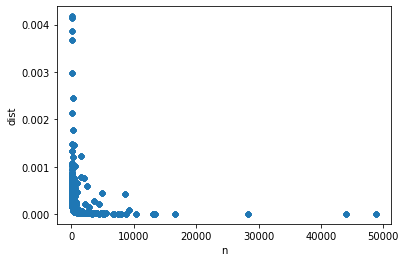

In [23]:
devi.plot(x='n', y='dist', kind='scatter')

Log-log scale: There is a pattern. When the number of cases increases, the distance or variabilty of the cases decreases.

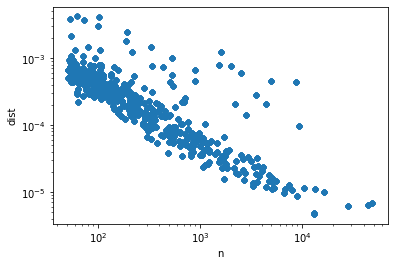

In [24]:
devi.plot(x='n', y='dist', kind='scatter', logx=True, logy=True)

In the reference document, they mention that they are interested in the points that have high y-values relative to their x-neighbors (the outliers).

To find them, a robust linear model (rlm) is fit and the residuals are plotted. The rlm code is obtained from [statsmodel](https://www.statsmodels.org/stable/index.html) library

In [26]:
# Train the linear model
regmodel = 'np.log(dist) ~ np.log(n)'

model = sm.rlm(formula=regmodel, data=devi)
results = model.fit()
resid = results.resid
# Store the residual values in devi
devi['residual'] = resid

Below, the first plot corresponds to the plot of all the residuals obtained from the rlm model without separation of 1.5

The second plot focuses only on those that are greater than 1.5

In [27]:
unusual = devi[devi['residual'] > 1.5]
hod4['residual'] = devi['residual']
hod_unusual = hod4[hod4['residual'] > 1.5]
hod_unusual_n = hod_unusual[hod_unusual['n'] > 350]

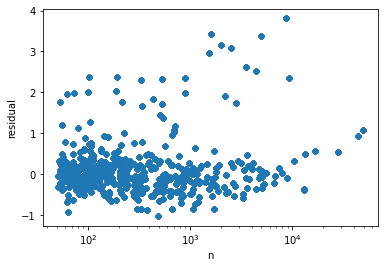

In [33]:
hod4.plot(x='n', y='residual', kind='scatter', logx=True)

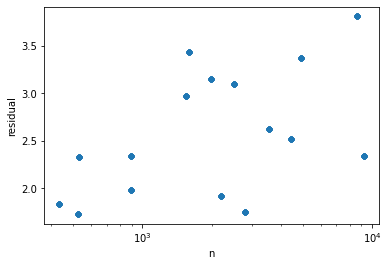

In [34]:
hod_unusual_n.plot(x='n', y='residual', kind='scatter', logx=True)